# Darshan-LDMS Integrator

A framework that integrates Darshan and LDMS to provide low-latency monitoring of I/O event data during runtime. 

**[Darshan](https://www.mcs.anl.gov/research/projects/darshan/)**: a lightweight I/O characterization tool that transparently captures application I/O behavior from HPC applications with minimal overhead.

**[Lightweight Distributed Metric Service (LDMS)](https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-quickstart.html)**: a low-overhead production monitoring system that can run on 
HPC machines. Capability to collect, transport, aggregate and store timeseries data during runtime.

![Darshan-LDMS Integration](Darshan-LDMSIntegration.png)

### Main benefits

- Storage in CSV format: easier to be processed by most data analysis tools
- Absolute time-series data with higher granularity: can be used to detect I/O-related runtime bottlenecks, captures more details about the execution
- Captures read/write/close/open/flushes
- Captures POSIX, MPI-IO and STDIO
- Captures and distincts between STDIN/STDOUT/STDERR for POSIX opens

### Local installation

- LDMS-Darshan Integration is available on Darshan's main branch: https://github.com/darshan-hpc/darshan/blob/main/darshan-runtime/lib/darshan-ldms.c
- Instructions to install LDMS streams and Darshan-LDMS Integration here: https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-streams.html#darshan

### [Installation in the cloud AWS](./aws_configuring.ipynb)

### Example file collected by the LDMS-Darshan Integrator

In [10]:
!head -n5 ./../ior/eclipse/darshan-ldms-output/csv/8m-4m/test_all_jobs.csv

uid,exe,job_id,rank,ProducerName,file,record_id,module,type,max_byte,switches,flushes,cnt,op,pt_sel,irreg_hslab,reg_hslab,ndims,npoints,off,len,start,dur,total,timestamp
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,17901504,0,n19,<STDIN>,92233720368547758,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,1702064106.980885
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,17901504,0,n19,<STDOUT>,92233720368547758,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,1702064106.980885
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,17901504,0,n19,<STDERR>,72382572414791935,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,1702064106.980885
12345,N/A,17901504,0,n19,N/A,92233720368547758,STDIO,MOD,51,-1,0,1,write,-1,-1,-1,-1,-1,0,52,0.024641,0.000008,0.000008,1702064107.005534



## Performance analysis and diagnosis of parallel I/O applications

Our goal is to close the gap between tracing and diagnosing of I/O applications using LDMS-Darshan integration logs. Darshan-LDMS is a framework that integrates Darshan and LDMS to provide low-latency monitoring of I/O event data during runtime. Absolute timestamps can be used to diagnose these bottlenecks by correlating the I/O logs with other system monitoring logs - deeper dive into the source of the problem.

![static analysis post collecting data](static_analysis.png)

#### Input data

LDMS-Darshan Integration CSV file. We have examples for experiments with the HPC [IOR benchmark](https://github.com/hpc/ior) in [this directory](https://github.com/anaveroneze/ldms-darshan-analysis/tree/main/ior/eclipse/darshan-ldms-output/csv/8m-4m). Each file constains information about a single job executions, but the analysis code can analyse and provide results about distinct jobs in the same file.

#### Output

- Jobs summary file
- Load imbalance evaluation
- Visualizations

#### Load Imbalance Metrics

To measure the overall I/O load distribution among the ranks utilized.

**Average/Norm**: Measures the mean load per rank.

$$
\text{AVG} = \frac{\text{Total Load}}{\text{Number of ranks}}
$$

**Imbalance time**: Measures the load that would be gained with an ideal load distribution between ranks.

$$
\text{IT} = \text{Maximum Load} - \text{AVG}
$$

**Percent Imbalance**: Measures the performance that could be gained with an ideal load distribution.

$$
\text{PI} = \left( \frac{\text{Maximum Load}}{\text{AVG}} - 1 \right) \times 100
$$


**Imbalance Percentage**: Measures the time that the ranks, excluding the slowest one, are not involved in computing.

$$
\text{IP} = \left( \frac{\text{Maximum Load} - \text{AVG}}{\text{Maximum Load}} \right) \times \left( \frac{\text{Number of ranks}}{\text{Number of ranks} - 1} \right)
$$

<!--   
#### TODOs
- [ ] Convert visualization in R to python
- [ ] Identify app phase - bottlenecks diagnosis during runtime
- [ ] Identify longer operations 
- [ ] Identify long intervals between last read/write and a met operation open/close 
- [ ] Identify distance between the first rank to finish and others
- [ ] Identify long intervals between operations in the same rank -->

## Code for capturing statistics about the execution:

In [1]:
import os, csv, time, glob, argparse, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt 
import rpy2.robjects as ro
import seaborn as sns
from datetime import datetime

class Job:

    def __init__(self, job, ranks, nodes, users, filename, exe):
        
        self.job = job
        self.ranks = ranks
        self.nodes = nodes
        self.users = users
        self.filename = filename
        self.exe = exe

def app_phase(df, output_file, self):
    write_to_file("---------------------------------------")
    write_to_file("EXECUTION SUMMARY PER APPLICATION PHASE:")
    write_to_file("---------------------------------------")

# Calculate and write general statistics in a file
def get_statistics(df, output_file, self):

    with open(output_file, 'w') as f:

        def write_to_file(*args):
            print(" ".join(map(str, args)), file=f, flush=True)

        write_to_file("---------------------------------------")
        write_to_file("JOB CHARACTERISTICS:")
        write_to_file("---------------------------------------")
        write_to_file("Job ID:", self.job)
        write_to_file(len(self.ranks), "Rank (s):", sorted(self.ranks))
        write_to_file(len(self.nodes), "Node (s):", sorted(self.nodes))
        write_to_file("User ID:", self.users)
        write_to_file("Directory:", self.exe)
        write_to_file("Modules collected:", df['module'].unique())
        write_to_file("Module data (MOD):", list(df.type).count('MOD'))
        write_to_file("Meta data (MET):", list(df.type).count('MET'))
        exec_time = round(df['end'].max() - df['start'].min(), 5)
        write_to_file("I/O runtime:", exec_time, "seconds")
        write_to_file("Bandwidth (MiB/second):", round((df['len'].sum() / exec_time) / (1024 ** 2), 2))

        df_rw = df[df['op'].isin(["read", "write"])]
        df_read = df[df['op'] == "read"]
        df = df[df['op'] == "write"]

        write_to_file("---------------------------------------")
        write_to_file("I/O OPERATIONS:")
        write_to_file("---------------------------------------")

        current_op = None
        phase_start = None
        total_durations = {'read': 0, 'write': 0, 'open': 0, 'close': 0}

        def update_total_duration(op, phase_start, phase_end, length):
            if current_op is not None and current_op == op:
                total_durations[op] += (phase_end - phase_start)

        for index, row in df.iterrows():
            if current_op is None or current_op != row['op']:
                update_total_duration(current_op, phase_start, row['end'], row['len'])
                current_op = row['op']
                phase_start = row['start']

        # Get the last phase
        update_total_duration(current_op, phase_start, row['end'], row['len'])

        pivot_df = df.pivot_table(index=None, columns='op', values='len', aggfunc='sum')
        for op, duration in total_durations.items():
            write_to_file(f'Duration {op}s: {round(duration, 4)} seconds')
            # if op == "read" or op == "write":
            #     print(op)
            #     bytesproc = round((pivot_df[op].max() / (1024 ** 2)) / duration, 4)
            #     write_to_file("Bandwidth:", bytesproc, "(MiB/second)")

        write_to_file("\nREADS:", round(df_read['len'].sum() / (1024 ** 2)),  "(MiB)")
        write_to_file("Max size per rank:", round(df_read.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        write_to_file("Min size per rank:", round(df_read.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Bandwidth (MiB/second):", round((df_read['len'].sum() / (df_read['end'].max() - df_read['start'].min())) / (1024 ** 2), 2))
        
        write_to_file("\nWRITES:", round(df['len'].sum() / (1024 ** 2)), "(MiB)")
        write_to_file("Max size per rank:", round(df.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        write_to_file("Min size per rank:", round(df.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Bandwidth (MiB/second):", round((df['len'].sum() / (df['end'].max() - df['start'].min())) / (1024 ** 2),2))

        # IMBALANCE METRICS:
        write_to_file("---------------------------------------")
        write_to_file("LOAD IMBALANCE METRICS:")
        write_to_file("---------------------------------------")
        # Get difference between execution time and time processing I/O per rank
        df_idle = df.groupby('rank')['dur'].sum().reset_index()
        df_idle.columns = ['Rank', 'I/O Time']
        df_idle['Total time - I/O Time'] = exec_time - df_idle['I/O Time']
        df_idle = df_idle.sort_values(by='Total time - I/O Time', ascending=False)

        write_to_file("Total execution time:", exec_time)
        num_ranks = df_idle['I/O Time'].nunique()
        average = df_idle['I/O Time'].sum() / num_ranks
        write_to_file("- Average Load per Rank:", round(average), "seconds")
        it = df_idle['I/O Time'].max() - average
        write_to_file("- Imbalance Time:", round(it, 2), "seconds")
        pi = ((df_idle['I/O Time'].max() / average) - 1) * 100
        write_to_file("- Percent Imbalance:", round(pi, 2), "%")
        ip = (it / df_idle['I/O Time'].max()) * (num_ranks / (num_ranks - 1))
        write_to_file("- Imbalance Percentage:", round(ip, 2), "%")
        std = np.std(df_idle['I/O Time'])
        write_to_file("- Standard deviation", round(std, 2))

        write_to_file("---------------------------------------")
        write_to_file("SUMMARY PER RANK: ")
        write_to_file("---------------------------------------")
        write_to_file("Total time without executing I/O operations:")
        df['start'] = pd.to_datetime(df['start'], unit='s').dt.round('S')
        df['end'] = pd.to_datetime(df['end'], unit='s').dt.round('S')
        write_to_file(df_idle)

## Code for visualizations in Python:

In [3]:
def plot_load_time_slice(df, filepath, job_id, op_name):

    df = df[df['len']>0 ]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 
    df.loc[:,'timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.round('S')
    df.loc[:,'dur'] = pd.to_timedelta(df['dur'], unit='s').dt.round('S')
    df.loc[:,'start'] = df['timestamp'] - df['dur']
    distinct_dates = df['start'].dt.date.unique()
    # df.loc[:,'rank_time'] = df['start'] - min(df['start'])
    df.loc[:,'rank_time'] = pd.cut(df['start'], bins=20)
    df = df.groupby(by=["rank","rank_time"])["len"].sum().reset_index()

    df['rank_time'] = df['rank_time'].apply(lambda x: x.left.strftime('%H:%M:%S'))
    df.loc[:,'len'] = df['len'] / 1024 / 1024
    df = df.pivot(index="rank", columns="rank_time", values="len")

    sns.heatmap(ax=ax, data=df, cmap="mako", cbar_kws={'label': 'MiB processed'})
    ax.set_ylabel("Rank")
    ax.set_xlabel("Timestamp")
    figure_title = ', '.join(map(str, distinct_dates.astype(str)))
    plt.title(f'Op: {op_name} - Dates: {figure_title}')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    fig.patch.set_facecolor('white')
    print("Saving figure in:", filepath + "fig1" + str(job_id) + "-" + op_name + ".png")
    plt.savefig(filepath + "fig1" + str(job_id) + "-" + op_name + ".png")
    plt.show()
    plt.close()
    plt.clf()

def plot_bandwidth_per_rank(df, filepath, job_id, op_name):

    plt.figure(figsize=(5, 1))
    df_bw = df.groupby('rank').agg(bw=('len', 'sum'))
    df_bw['bw'] = round(df_bw['bw'] / (2 ** 20) / df['dur'].sum(), 2)
    df = pd.merge(df, df_bw, on='rank')

    heatmap_data = df.pivot_table(index='op', columns='rank', values='bw', aggfunc='sum')
    sns.heatmap(heatmap_data, cmap='viridis', fmt=".1f", cbar_kws={'label': 'Bandwidth\n(MiB/seconds)'})

    plt.xlabel('Rank ID')
    plt.ylabel('')
    plt.title('')
    
    plt.savefig(filepath + "fig2" + str(job_id) + "-" + op_name + ".png")
    plt.show()
    plt.clf()
    plt.close()

def get_visualizations_py(df, filepath, job_id):

    #################################################################
    # WRITE OPERATIONS
    #################################################################
    df_op = pd.DataFrame()
    df_op = df[df['op'] == "write"].copy()
    plot_load_time_slice(df_op, filepath, job_id, "write")
    plot_bandwidth_per_rank(df_op, filepath, job_id, "write")
    #################################################################
    # READ OPERATIONS
    #################################################################
    df_op = pd.DataFrame()
    df_op = df[df['op'] == "read"].copy()
    plot_load_time_slice(df_op, filepath, job_id, "read")
    plot_bandwidth_per_rank(df_op, filepath, job_id, "read")
    return 

def get_visualizations_R(filename, filepath):

    r = ro.r
    r.source(filepath + "temporal_vis.R")
    r.plot_temporal(filepath + "teste1.png")
    r.plot_long_temporal(filepath + "teste2.png")
    r.plot_max_temporal(filepath + "teste3.png")
    r.plot_bandwidth_per_rank(filepath + "teste4.png")
    r.plot_duration(filepath + "teste5.png")

    return 

## Run to get jobs report:

In [6]:
# Read CSV file, define jobs characteristics and calculate load metrics
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        job = Job(i, local_df['rank'].unique(), local_df['ProducerName'].unique(),local_df['uid'].unique(), 
            local_df['file'].unique(), local_df['exe'].unique())

        local_df.loc[:, 'start'] = local_df['timestamp'] - local_df['dur']
        local_df.loc[:, 'end'] = local_df['timestamp']
        
        # Job characteristics and statistics:  
        output_file = filename.replace(".csv", ".txt")
        get_statistics(local_df, output_file, job)

if __name__ == '__main__':

    start_time_exec = time.time()
    # filename = input('Insert absolut LDMS-Darshan log path:')
    INPUTFILE="/home/ana/Documents/2023/ldms-darshan-analysis/ior/eclipse/darshan-ldms-output/csv/8m-4m/17901504-IOR_pscratch_1024_none.csv"
    FILEPATH="/home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/"
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")

Execution time: 3.3204903602600098 seconds


/tmp/ipykernel_938132/2428781250.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start'] = pd.to_datetime(df['start'], unit='s').dt.round('S')
/tmp/ipykernel_938132/2428781250.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end'] = pd.to_datetime(df['end'], unit='s').dt.round('S')


## Checking output file:

In [9]:
!cat ./../ior/eclipse/darshan-ldms-output/csv/8m-4m/17901504-IOR_pscratch_1024_none.txt

---------------------------------------
JOB CHARACTERISTICS:
---------------------------------------
Job ID: 17901504
36 Rank (s): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
1 Node (s): ['n19']
User ID: [12345]
Directory: ['/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior' 'N/A']
Modules collected: ['STDIO' 'POSIX']
Module data (MOD): 147672
Meta data (MET): 75
I/O runtime: 110.26556 seconds
Bandwidth (MiB/second): 5349.12
---------------------------------------
I/O OPERATIONS:
---------------------------------------
Duration reads: 0 seconds
Duration writes: 110.2409 seconds
Duration opens: 0 seconds
Duration closes: 0 seconds

READS: 294912 (MiB)
Max size per rank: 8192 MiB
Min size per rank: 8192 MiB
Bandwidth (MiB/second): 3871.94

WRITES: 294912 (MiB)
Max size per rank: 8192 MiB
Min size per rank: 8192 MiB
Bandwidth (MiB/second): 2675.16
---------------------------------------

## Run to get visualizations:

/tmp/ipykernel_938132/3999255725.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'rank_time'] = pd.cut(df['start'], bins=20)


Saving figure in: /home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/fig117901504-write.png


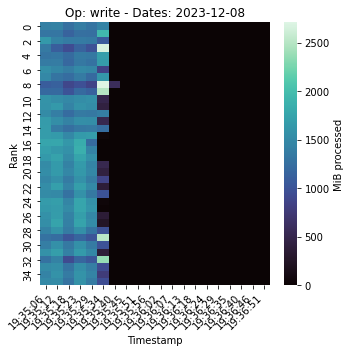

<Figure size 432x288 with 0 Axes>

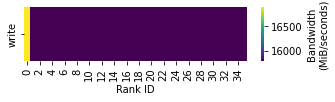

Saving figure in: /home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/fig117901504-read.png


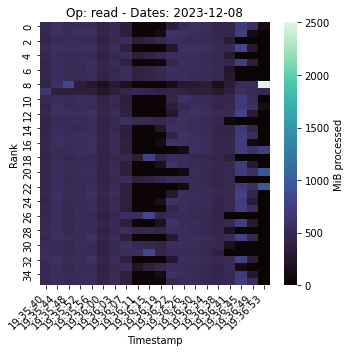

<Figure size 432x288 with 0 Axes>

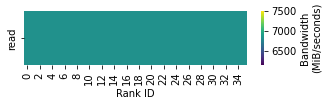

Execution time: 1.555558443069458 seconds


In [10]:
# Read file and get visualizations
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        job = Job(i, local_df['rank'].unique(), local_df['ProducerName'].unique(),local_df['uid'].unique(), 
            local_df['file'].unique(), local_df['exe'].unique())

        local_df.loc[:, 'start'] = local_df['timestamp'] - local_df['dur']
        local_df.loc[:, 'end'] = local_df['timestamp']

        # Job visualizations
        get_visualizations_py(local_df, filepath, i)

        # get_visualizations_R(args.input, "./figures/ior/teste.png")

    # if(system):
    #     correlate_system(args.input, args.system)

if __name__ == '__main__':

    start_time_exec = time.time()
    # filename = input('Insert absolut LDMS-Darshan log path:')
    INPUTFILE="/home/ana/Documents/2023/ldms-darshan-analysis/ior/eclipse/darshan-ldms-output/csv/8m-4m/17901504-IOR_pscratch_1024_none.csv"
    FILEPATH="/home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/"
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")

In [ ]:
# Read file and define jobs characteristics
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        job = Job(i, local_df['rank'].unique(), local_df['ProducerName'].unique(),local_df['uid'].unique(), 
            local_df['file'].unique(), local_df['exe'].unique())

        local_df.loc[:, 'start'] = local_df['timestamp'] - local_df['dur']
        local_df.loc[:, 'end'] = local_df['timestamp']
        
        # Job characteristics and statistics:  
        output_file = filename.replace(".csv", ".txt")
        get_statistics(local_df, output_file, job)

        # Job visualizations
        get_visualizations_py(local_df, filepath, i)

        # get_visualizations_R(args.input, "./figures/ior/teste.png")

    # if(system):
    #     correlate_system(args.input, args.system)

if __name__ == '__main__':

    start_time_exec = time.time()
    # filename = input('Insert absolut LDMS-Darshan log path:')
    INPUTFILE="/home/ana/Documents/2023/ldms-darshan-analysis/ior/eclipse/darshan-ldms-output/csv/8m-4m/17901504-IOR_pscratch_1024_none.csv"
    FILEPATH="/home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/"
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")

# Visualizations in R

Load libraries: